Importamos las librerias necesarias para el proyecto

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from pycaret.classification import *
import joblib
import warnings


RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

Cargamos los datos del proyecto

In [5]:
demand_data = pd.read_csv('dataset_demand_acumulate.csv')
alpha_beta_data = pd.read_csv('dataset_alpha_betha.csv')
to_predict_data = pd.read_csv('to_predict.csv')
print(demand_data.columns)
print(demand_data.head)
print(demand_data.describe())

Index(['year_month', 'Demand'], dtype='object')
<bound method NDFrame.head of    year_month       Demand
0     2017-01  1211.009490
1     2017-02  1660.584649
2     2017-03  3182.587014
3     2017-04  3506.515270
4     2017-05  4554.082280
..        ...          ...
59    2021-12  3006.311107
60    2022-01   217.314949
61    2022-02   332.062614
62    2022-03   609.119726
63    2022-04  1048.486287

[64 rows x 2 columns]>
            Demand
count    64.000000
mean   2600.044986
std    1943.995938
min     217.314949
25%    1034.370651
50%    1947.817229
75%    4216.465081
max    7686.307292


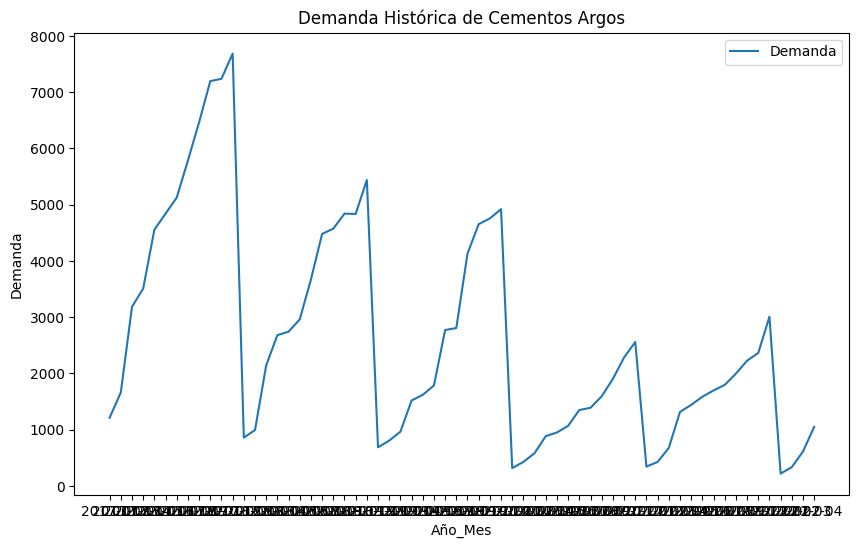

In [8]:
# Visualización de la demanda histórica
plt.figure(figsize=(10,6))
plt.plot(demand_data['year_month'], demand_data['Demand'], label='Demanda')
plt.xlabel('Año_Mes')
plt.ylabel('Demanda')
plt.title('Demanda Histórica de Cementos Argos')
plt.legend()
plt.show()

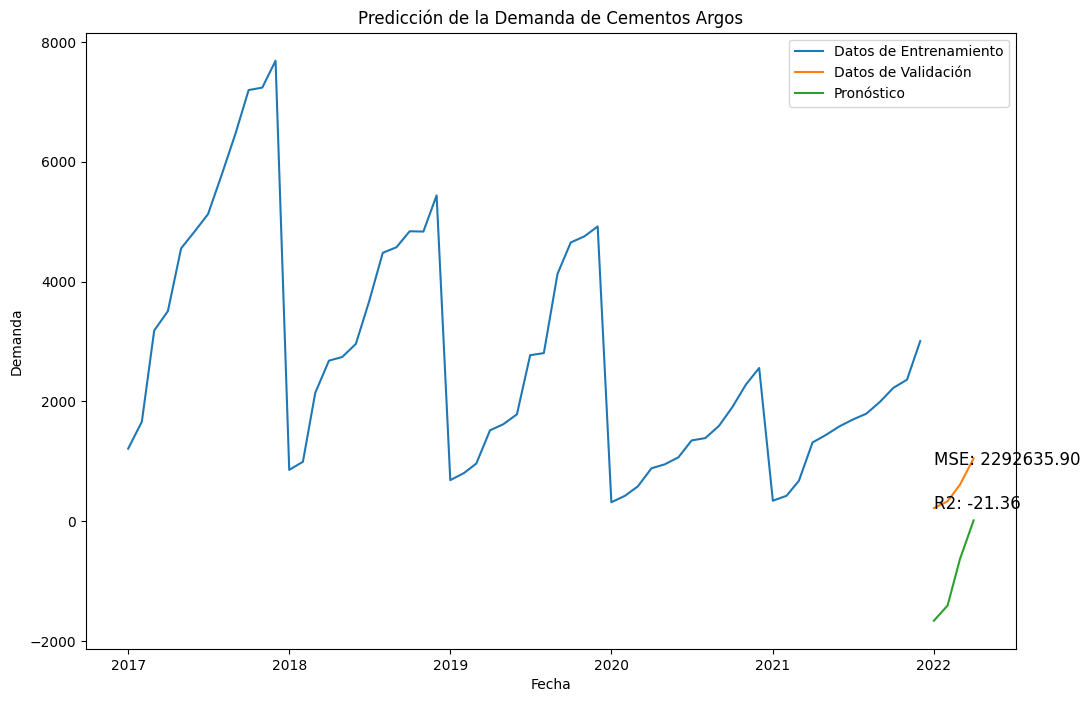

In [25]:
# Modelado de la demanda

# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01']
test_data = demand_data[demand_data['year_month'] >= '2022-01-01']

# Modelado de la demanda
model = ExponentialSmoothing(train_data['Demand'], seasonal='add', seasonal_periods=12).fit()
steps_ahead = len(test_data)
demand_forecast = model.forecast(steps=steps_ahead)

# Añadir los pronósticos al dataframe de prueba
test_data = test_data.reset_index(drop=True)  # Asegurarse de que el índice es continuo
test_data['Forecast'] = demand_forecast.values[:steps_ahead]

# Evaluación del modelo
mse = mean_squared_error(test_data['Demand'], test_data['Forecast'])
r2 = r2_score(test_data['Demand'], test_data['Forecast'])


# Graficar los resultados
plt.figure(figsize=(12,8))
plt.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
plt.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')
plt.plot(test_data['year_month'], test_data['Forecast'], label='Pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Predicción de la Demanda de Cementos Argos')
plt.legend()


# Añadir las métricas al gráfico
plt.text(test_data['year_month'].min(), test_data['Demand'].max() * 0.9, f'MSE: {mse:.2f}', fontsize=12, color='black')
plt.text(test_data['year_month'].min(), test_data['Demand'].max() * 0.2, f'R2: {r2:.2f}', fontsize=12, color='black')

plt.show()

C:\Users\aruiz73\AppData\Local\Temp\ipykernel_25060\3383241777.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
C:\Users\aruiz73\AppData\Local\Temp\ipykernel_25060\3383241777.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]


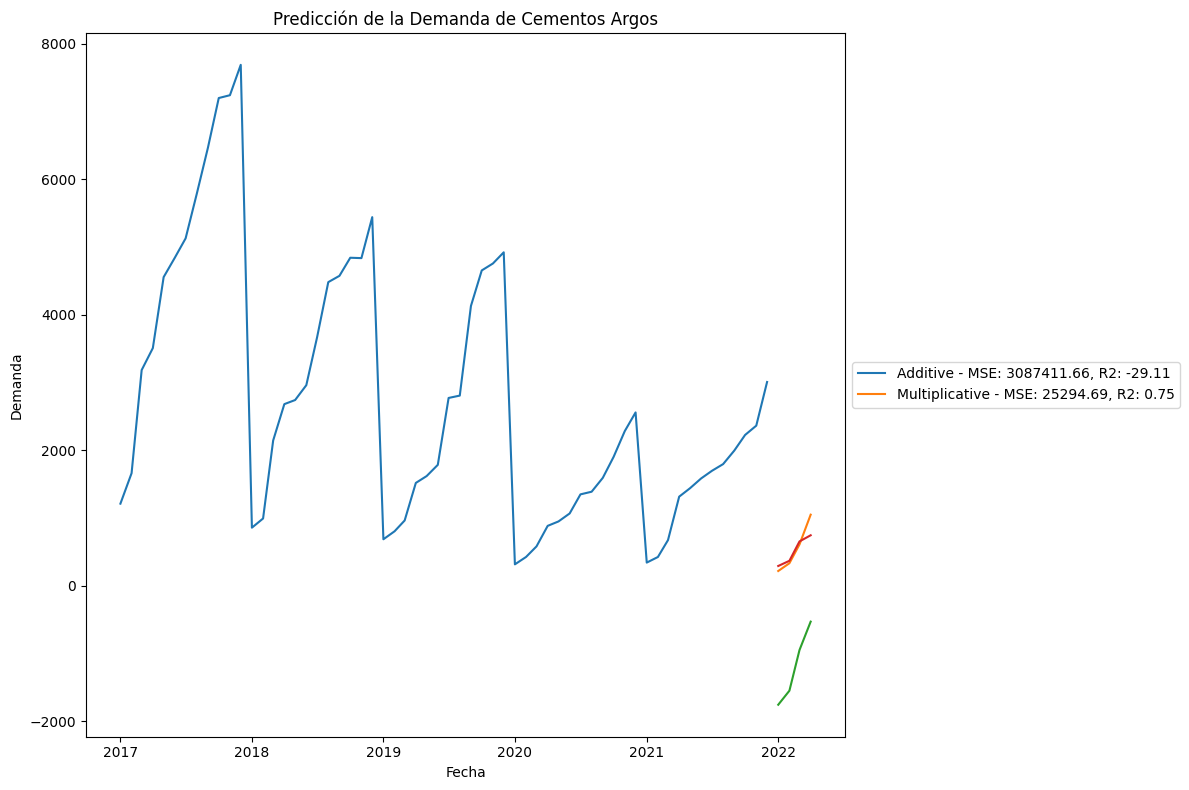

In [14]:
# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01']
test_data = demand_data[demand_data['year_month'] >= '2022-01-01']

# Ajuste de diferentes modelos Holt-Winters
models = {
    'Additive': ExponentialSmoothing(train_data['Demand'], trend='add', seasonal='add', seasonal_periods=12).fit(),
    'Multiplicative': ExponentialSmoothing(train_data['Demand'], trend='add', seasonal='mul', seasonal_periods=12).fit()
}

# Evaluación de los modelos
results = {}
for model_name, model in models.items():
    steps_ahead = len(test_data)
    demand_forecast = model.forecast(steps=steps_ahead)
    test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
    
    mse = mean_squared_error(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    r2 = r2_score(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    results[model_name] = {'mse': mse, 'r2': r2}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento y validación
ax.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
ax.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')

# Graficar los pronósticos
for model_name in models.keys():
    ax.plot(test_data['year_month'], test_data[f'Forecast_{model_name}'], label=f'Pronóstico {model_name}')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.set_title('Predicción de la Demanda de Cementos Argos')

# Añadir la leyenda al lado derecho del gráfico
legend_texts = [f'{model_name} - MSE: {metrics["mse"]:.2f}, R2: {metrics["r2"]:.2f}' for model_name, metrics in results.items()]
ax.legend(legend_texts, loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aruiz73\AppData\Local\Temp\ipykernel_25060\2075889891.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'Forecast_{

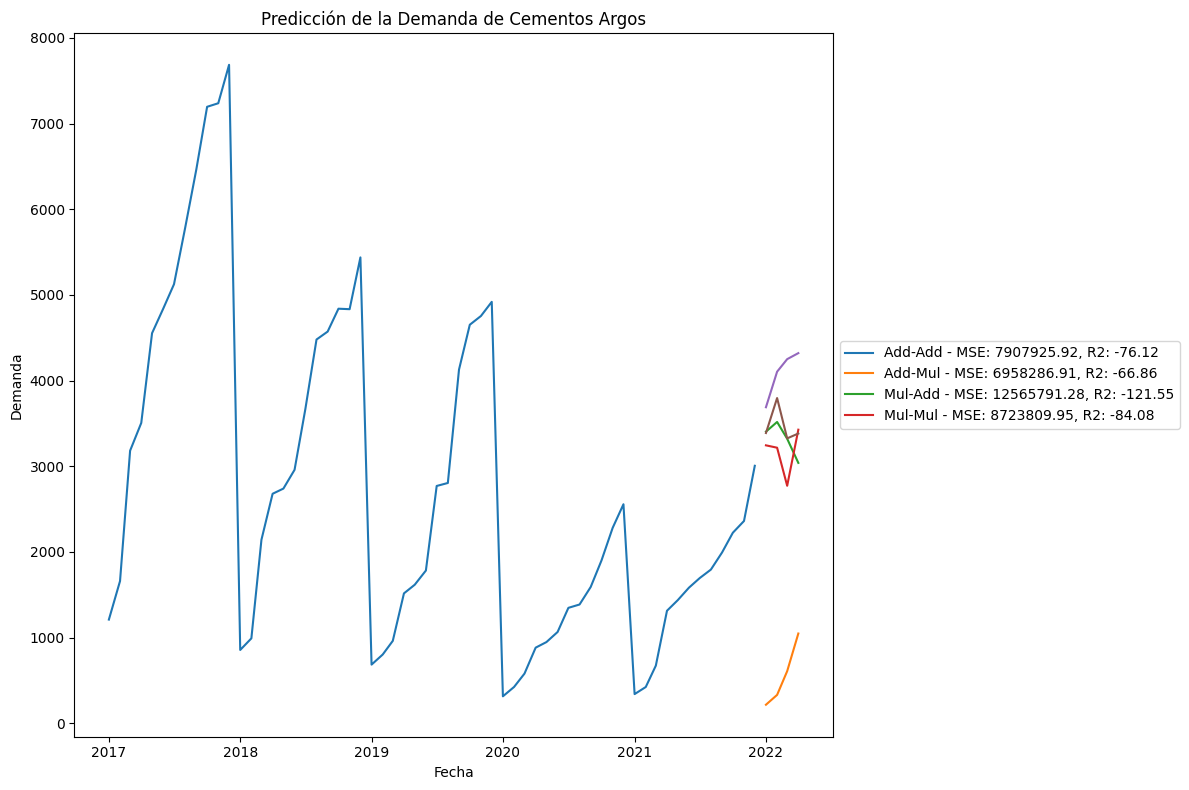

In [28]:
# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01']
test_data = demand_data[demand_data['year_month'] >= '2022-01-01']

# Ajuste de diferentes modelos Holt-Winters con prueba de diferentes configuraciones
configs = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

models = {}
for trend, seasonal in configs:
    model = ExponentialSmoothing(train_data['Demand'], trend=trend, seasonal=seasonal, seasonal_periods=5).fit()
    model_name = f'{trend.capitalize()}-{seasonal.capitalize()}'
    models[model_name] = model

# Evaluación de los modelos
results = {}
for model_name, model in models.items():
    steps_ahead = len(test_data)
    demand_forecast = model.forecast(steps=steps_ahead)
    test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
    
    mse = mean_squared_error(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    r2 = r2_score(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    results[model_name] = {'mse': mse, 'r2': r2}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento y validación
ax.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
ax.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')

# Graficar los pronósticos
for model_name in models.keys():
    ax.plot(test_data['year_month'], test_data[f'Forecast_{model_name}'], label=f'Pronóstico {model_name}')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.set_title('Predicción de la Demanda de Cementos Argos')

# Añadir la leyenda al lado derecho del gráfico
legend_texts = [f'{model_name} - MSE: {metrics["mse"]:.2f}, R2: {metrics["r2"]:.2f}' for model_name, metrics in results.items()]
ax.legend(legend_texts, loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


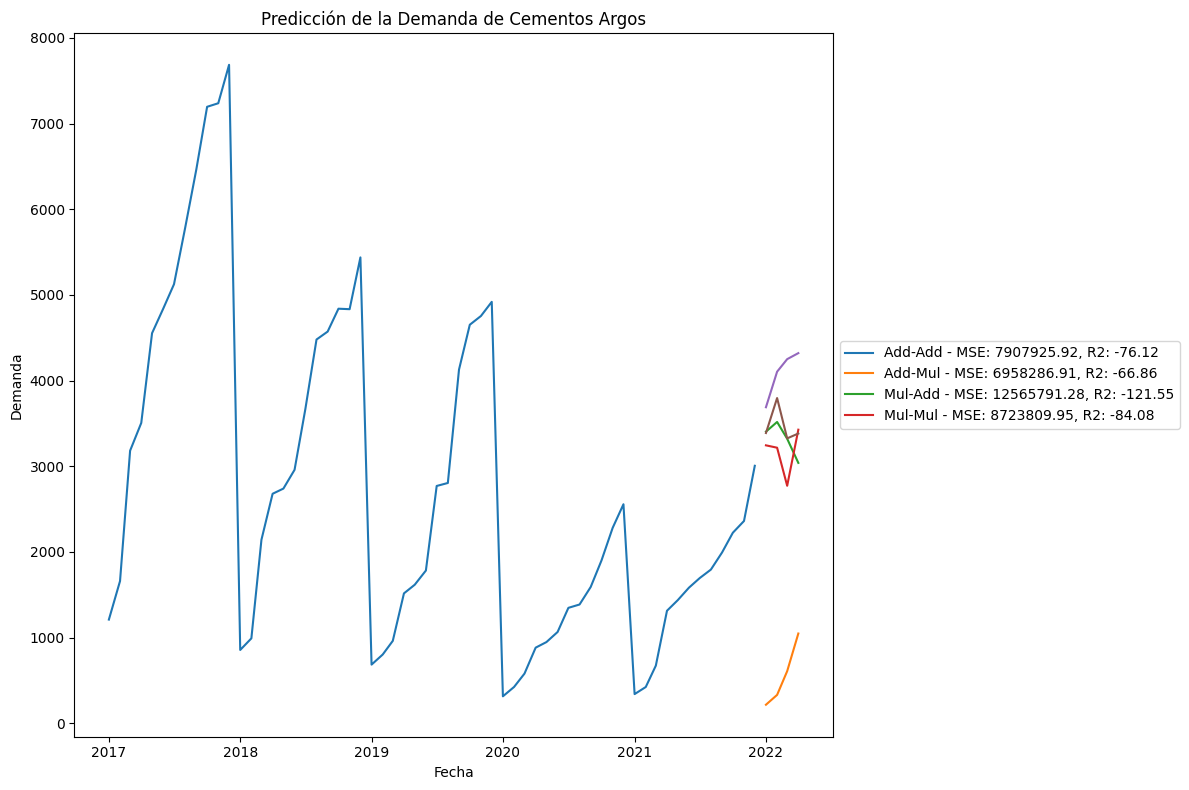

Modelo: Add-Add
MSE: 7907925.92
R2: -76.12
---
Modelo: Add-Mul
MSE: 6958286.91
R2: -66.86
---
Modelo: Mul-Add
MSE: 12565791.28
R2: -121.55
---
Modelo: Mul-Mul
MSE: 8723809.95
R2: -84.08
---


In [38]:
# Ignorar advertencias de SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01'].copy()
test_data = demand_data[demand_data['year_month'] >= '2022-01-01'].copy()

# Ajuste de diferentes modelos Holt-Winters con prueba de diferentes configuraciones
configs = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

models = {}
for trend, seasonal in configs:
    try:
        model = ExponentialSmoothing(train_data['Demand'], trend=trend, seasonal=seasonal, seasonal_periods=5).fit()
        model_name = f'{trend.capitalize()}-{seasonal.capitalize()}'
        models[model_name] = model
    except Exception as e:
        print(f"Error fitting model {trend}-{seasonal}: {e}")

# Evaluación de los modelos
results = {}
for model_name, model in models.items():
    steps_ahead = len(test_data)
    demand_forecast = model.forecast(steps=steps_ahead)
    test_data.loc[:, f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
    
    mse = mean_squared_error(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    r2 = r2_score(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    results[model_name] = {'mse': mse, 'r2': r2}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento y validación
ax.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
ax.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')

# Graficar los pronósticos
for model_name in models.keys():
    ax.plot(test_data['year_month'], test_data[f'Forecast_{model_name}'], label=f'Pronóstico {model_name}')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.set_title('Predicción de la Demanda de Cementos Argos')

# Añadir la leyenda al lado derecho del gráfico
legend_texts = [f'{model_name} - MSE: {metrics["mse"]:.2f}, R2: {metrics["r2"]:.2f}' for model_name, metrics in results.items()]
ax.legend(legend_texts, loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir los modelos junto con sus métricas
for model_name, metrics in results.items():
    print(f'Modelo: {model_name}')
    print(f'MSE: {metrics["mse"]:.2f}')
    print(f'R2: {metrics["r2"]:.2f}')
    print('---')

c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


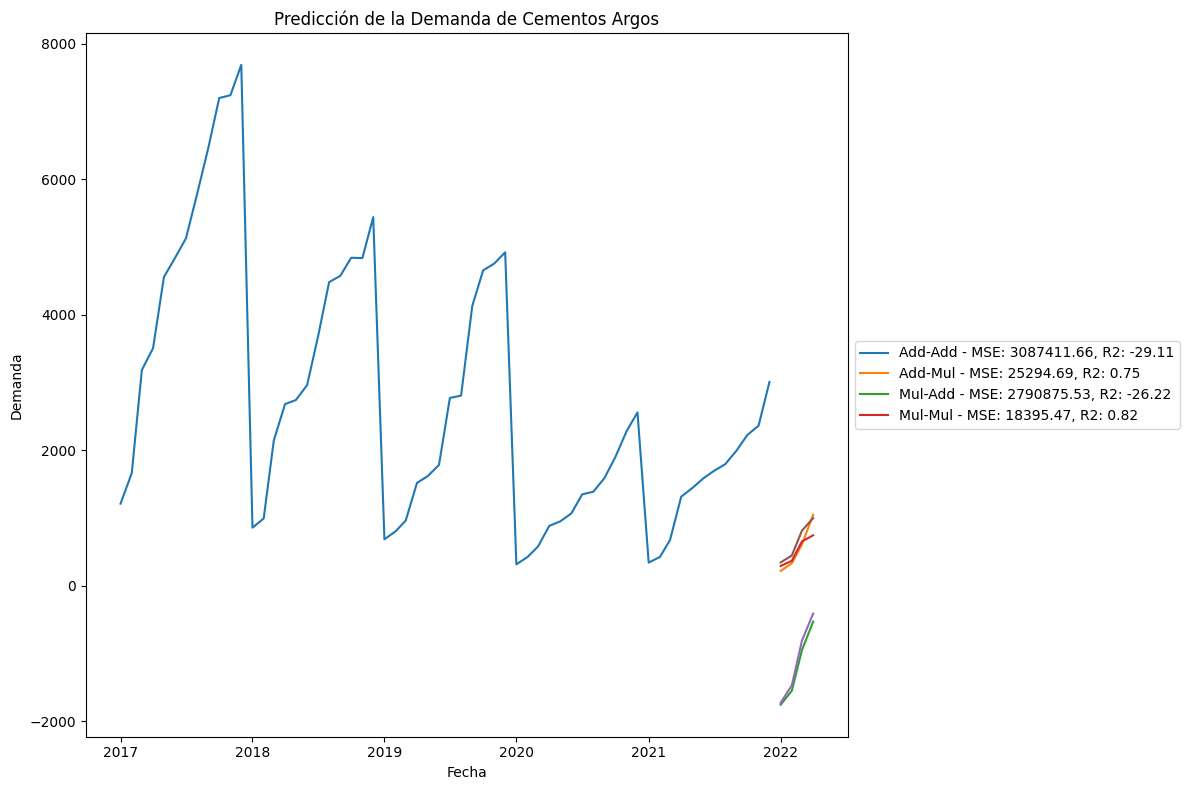

Modelo: Add-Add
MSE: 3087411.66
R2: -29.11
---
Modelo: Add-Mul
MSE: 25294.69
R2: 0.75
---
Modelo: Mul-Add
MSE: 2790875.53
R2: -26.22
---
Modelo: Mul-Mul
MSE: 18395.47
R2: 0.82
---


In [39]:
# Ignorar advertencias de SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01'].copy()
test_data = demand_data[demand_data['year_month'] >= '2022-01-01'].copy()

# Ajuste de diferentes modelos Holt-Winters con prueba de diferentes configuraciones
configs = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

models = {}
for trend, seasonal in configs:
    try:
        model = ExponentialSmoothing(train_data['Demand'], trend=trend, seasonal=seasonal, seasonal_periods=12).fit()
        model_name = f'{trend.capitalize()}-{seasonal.capitalize()}'
        models[model_name] = model
    except Exception as e:
        print(f"Error fitting model {trend}-{seasonal}: {e}")

# Evaluación de los modelos
results = {}
for model_name, model in models.items():
    steps_ahead = len(test_data)
    demand_forecast = model.forecast(steps=steps_ahead)
    test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
    
    mse = mean_squared_error(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    r2 = r2_score(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    results[model_name] = {'mse': mse, 'r2': r2}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento y validación
ax.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
ax.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')

# Graficar los pronósticos
for model_name in models.keys():
    ax.plot(test_data['year_month'], test_data[f'Forecast_{model_name}'], label=f'Pronóstico {model_name}')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.set_title('Predicción de la Demanda de Cementos Argos')

# Añadir la leyenda al lado derecho del gráfico
legend_texts = [f'{model_name} - MSE: {metrics["mse"]:.2f}, R2: {metrics["r2"]:.2f}' for model_name, metrics in results.items()]
ax.legend(legend_texts, loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir los modelos junto con sus métricas
for model_name, metrics in results.items():
    print(f'Modelo: {model_name}')
    print(f'MSE: {metrics["mse"]:.2f}')
    print(f'R2: {metrics["r2"]:.2f}')
    print('---')

c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\aruiz73\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


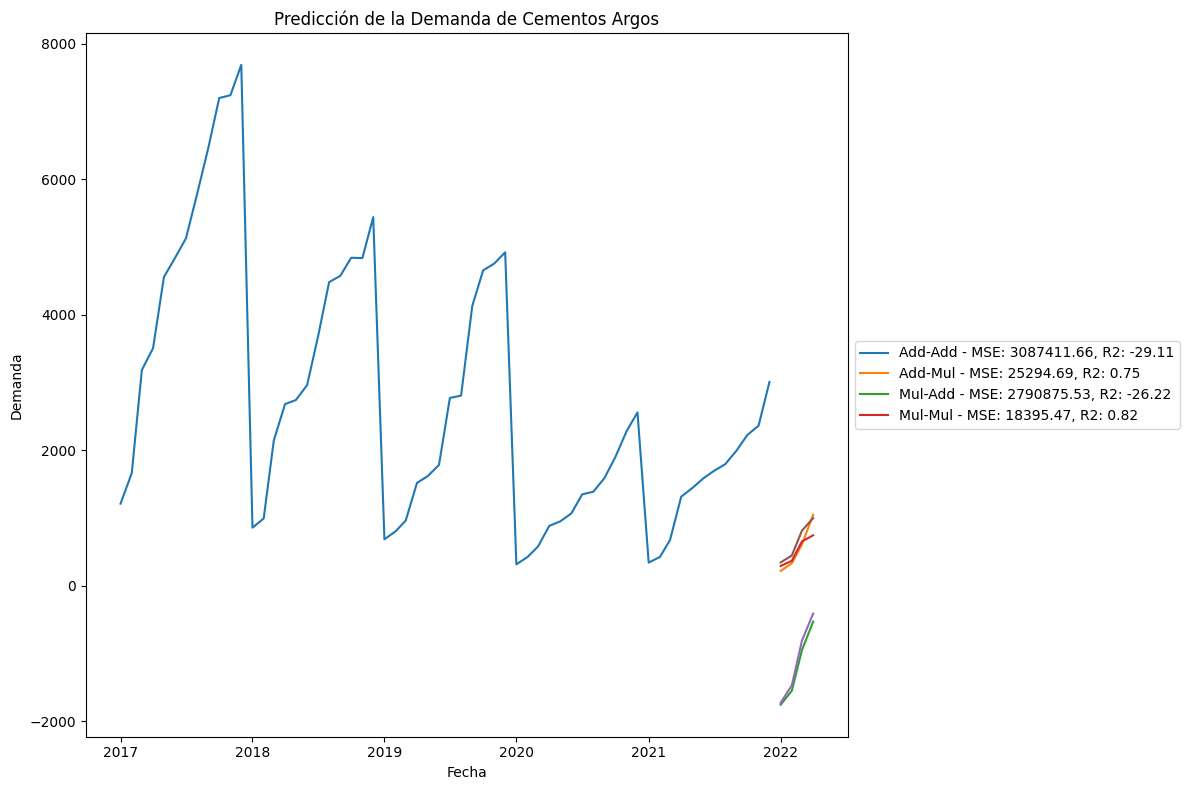

Modelo: Add-Add
MSE: 3087411.66
R2: -29.11
---
Modelo: Add-Mul
MSE: 25294.69
R2: 0.75
---
Modelo: Mul-Add
MSE: 2790875.53
R2: -26.22
---
Modelo: Mul-Mul
MSE: 18395.47
R2: 0.82
---


In [40]:
# Ignorar advertencias de SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Convertir la columna year_month a un formato datetime
demand_data['year_month'] = pd.to_datetime(demand_data['year_month'], format='%Y-%m')
train_data = demand_data[demand_data['year_month'] < '2022-01-01'].copy()
test_data = demand_data[demand_data['year_month'] >= '2022-01-01'].copy()

# Ajuste de diferentes modelos Holt-Winters con prueba de diferentes configuraciones
configs = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

models = {}
for trend, seasonal in configs:
    try:
        model = ExponentialSmoothing(train_data['Demand'], trend=trend, seasonal=seasonal, seasonal_periods=12).fit()
        model_name = f'{trend.capitalize()}-{seasonal.capitalize()}'
        models[model_name] = model
    except Exception as e:
        print(f"Error fitting model {trend}-{seasonal}: {e}")

# Evaluación de los modelos
results = {}
for model_name, model in models.items():
    steps_ahead = len(test_data)
    demand_forecast = model.forecast(steps=steps_ahead)
    test_data[f'Forecast_{model_name}'] = demand_forecast.values[:steps_ahead]
    
    mse = mean_squared_error(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    r2 = r2_score(test_data['Demand'], test_data[f'Forecast_{model_name}'])
    results[model_name] = {'mse': mse, 'r2': r2}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento y validación
ax.plot(train_data['year_month'], train_data['Demand'], label='Datos de Entrenamiento')
ax.plot(test_data['year_month'], test_data['Demand'], label='Datos de Validación')

# Graficar los pronósticos
for model_name in models.keys():
    ax.plot(test_data['year_month'], test_data[f'Forecast_{model_name}'], label=f'Pronóstico {model_name}')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.set_title('Predicción de la Demanda de Cementos Argos')

# Añadir la leyenda al lado derecho del gráfico
legend_texts = [f'{model_name} - MSE: {metrics["mse"]:.2f}, R2: {metrics["r2"]:.2f}' for model_name, metrics in results.items()]
ax.legend(legend_texts, loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir los modelos junto con sus métricas
for model_name, metrics in results.items():
    print(f'Modelo: {model_name}')
    print(f'MSE: {metrics["mse"]:.2f}')
    print(f'R2: {metrics["r2"]:.2f}')
    print('---')

Entrenar el modelo de clasificación

In [52]:
print(alpha_beta_data.head())


       autoID  SeniorCity Partner Dependents Service1          Service2  \
0  7590-VHVEG           0     Yes         No       No  No phone service   
1  5575-GNVDE           0      No         No      Yes                No   
2  3668-QPYBK           0      No         No      Yes                No   
3  7795-CFOCW           0      No         No       No  No phone service   
4  9237-HQITU           0      No         No      Yes                No   

  Security OnlineBackup DeviceProtection TechSupport        Contract  \
0       No          Yes               No          No  Month-to-month   
1      Yes           No              Yes          No        One year   
2      Yes          Yes               No          No  Month-to-month   
3      Yes           No              Yes         Yes        One year   
4       No           No               No          No  Month-to-month   

  PaperlessBilling              PaymentMethod  Charges   Demand  Class  
0              Yes           Electronic che

In [53]:
print(alpha_beta_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [54]:
print(alpha_beta_data.describe())

        SeniorCity      Charges
count  7043.000000  7043.000000
mean      0.162147    64.761692
std       0.368612    30.090047
min       0.000000    18.250000
25%       0.000000    35.500000
50%       0.000000    70.350000
75%       0.000000    89.850000
max       1.000000   118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

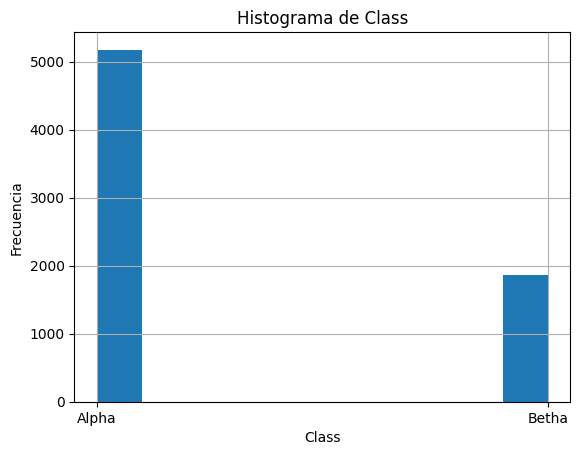

In [51]:
# Graficando el histograma para la columna 'class'
alpha_beta_data['Class'].hist()

# Añadiendo título y etiquetas
plt.title('Histograma de Class')
plt.xlabel('Class')
plt.ylabel('Frecuencia')

# Mostrando el gráfico
plt.show()

In [16]:



# Preprocesamiento
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)



Modelo y métricas guardadas correctamente.


In [ ]:
# Preprocesamiento
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
data = pd.get_dummies(alpha_beta_data, drop_first=True)

# Unir X y y para que PyCaret pueda procesarlo
data['Class'] = y

# Configurar PyCaret
clf = setup(data, target='Class', session_id=42, silent=True, preprocess=True)

# Comparar todos los modelos
best_model = compare_models()

# Crear un modelo específico, por ejemplo, RandomForestClassifier
rf_model = create_model('rf')

# Entrenar el modelo
rf_model = tune_model(rf_model)

# Evaluar el modelo
evaluate_model(rf_model)

# Hacer predicciones
predictions = predict_model(rf_model)
print(predictions)

In [ ]:
# Guardar el modelo y las métricas
joblib.dump(model, 'classification_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

with open('model_metrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(report)

print("Modelo y métricas guardadas correctamente.")

Crear la API

In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Cargar el modelo y el scaler
model = joblib.load('classification_model.pkl')
scaler = joblib.load('scaler.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame([data])
    
    # Preprocesamiento
    df = pd.get_dummies(df, drop_first=True)
    df_scaled = scaler.transform(df)
    
    # Predicción
    prediction = model.predict(df_scaled)
    
    return jsonify({'prediction': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)

Completar el archivo to_predict.csv

In [ ]:
# Supongamos que los pronósticos ya están guardados en una lista
demand_forecasts = [3000, 3200, 3400]  # Reemplazar con los valores reales pronosticados

# Añadir los pronósticos
to_predict_data['Demand'] = demand_forecasts

# Guardar el archivo
to_predict_data.to_csv('to_predict_completed.csv', index=False)

Realizar las peticiones al servicio

In [ ]:
import requests

# Cargar los datos completados
to_predict_data = pd.read_csv('to_predict_completed.csv')

# Realizar las peticiones al servicio
url = 'http://localhost:5000/predict'
results = []

for _, row in to_predict_data.iterrows():
    response = requests.post(url, json=row.to_dict())
    results.append(response.json())

# Guardar los resultados
results_df = pd.DataFrame(results)
results_df.to_csv('api_predictions.csv', index=False)